In [1]:
# librerie utili
import os
import torch
import numpy as np
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split, Subset
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import random
import collections
from tqdm import tqdm
import joblib 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torchvision.utils import make_grid
from datetime import datetime

In [2]:
# riproducibilità
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

In [3]:
# parametri principali
image_size = 224          # dimensione immagine (224x224)
batch_size = 128          # batch size per il DataLoader
encoding_dim = 323     # dimensione dello spazio latente dell'autoencoder
epochs = 30               # numero di epoche per l'allenamento
lr = 1e-3                 # learning rate per ottimizzatore
noise_std = 0.2          # rumore usato in fase di data augmentation
train_ratio, val_ratio = 0.7, 0.15  # percentuali per suddividere in train/val/test
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # utilizzo GPU se disponibile PROVA SENZA

pretty_labels = ['adenocarcinoma', 'beigno', 'carcinoma squamoso']  # nome delle classi più leggibili

In [4]:
# percorsi utili
base_dir = os.getcwd()  # percorso base
data_dir = os.path.join(base_dir, 'data_histo') # percorso dataset
# percorso per salvare output
output_folder = os.path.join(base_dir, "ae_outputs")
os.makedirs(output_folder, exist_ok=True) # crea se non esiste
save_path = os.path.join(output_folder, f'ae_data_{encoding_dim}_{noise_std}.pth')
encoder_model_path = os.path.join(output_folder, f'ae_encoder_CNN_{encoding_dim}_{noise_std}.pt')

In [5]:
# trasformazioni base (usate per val/test)
transform_base = transforms.Compose([
    transforms.Resize((image_size, image_size)), # ridimensiona le immagini
    transforms.ToTensor() # converte in tensore
])

In [6]:
# caricamento e split
full_dataset = datasets.ImageFolder(root=data_dir, transform=transform_base)  # carica tutte le immagini con le etichette
total_size = len(full_dataset)                                           # numero totale di immagini
train_size = int(train_ratio * total_size)
val_size = int(val_ratio * total_size)
test_size = total_size - train_size - val_size                           # il resto va al test set

# suddivisione casuale ma riproducibile
train_indices, val_indices, test_indices = random_split(
    list(range(total_size)), [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

In [7]:
train_subset = Subset(full_dataset, train_indices)
val_subset = Subset(full_dataset, val_indices)
test_subset = Subset(full_dataset, test_indices)

val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

In [8]:
# caricamento dati augmentati (vedi file augmented_data.ipynb)
aug_data = torch.load(os.path.join("shared_augmented_data", f"augmented_train_data_{noise_std}.pt"))
train_imgs = aug_data['images']
train_labels = aug_data['labels']

# flatten immagini in vettori 1D
train_data = train_imgs.view(train_imgs.size(0), -1).numpy()

In [9]:
# estrazione e flattening di val e test
def extract_data(loader):
    data, labels = [], []
    for images, targets in tqdm(loader, desc="Estrazione dati"):
        flat = images.view(images.size(0), -1)
        data.append(flat)
        labels.append(targets)
    data = torch.cat(data, dim=0).numpy()
    labels = torch.cat(labels).numpy()
    return data, labels

val_data, val_labels = extract_data(val_loader)
test_data, test_labels = extract_data(test_loader)

Estrazione dati: 100%|██████████| 18/18 [00:34<00:00,  1.89s/it]


In [10]:
# normalizzazione su disco
def normalize_to_memmap(data, mean, std, output_path, batch_size=100):
    shape = data.shape
    dtype = np.float16
    memmap_array = np.memmap(output_path, dtype=dtype, mode='w+', shape=shape)
    for i in range(0, shape[0], batch_size):
        batch = data[i:i+batch_size]
        norm_batch = (batch - mean) / std
        memmap_array[i:i+batch_size] = norm_batch.astype(dtype)
    del memmap_array  # flush

def compute_mean_std(data, batch_size=100):
    n_samples = data.shape[0]
    n_features = data.shape[1]

    total_sum = np.zeros(n_features, dtype=np.float64)
    total_sq_sum = np.zeros(n_features, dtype=np.float64)
    count = 0

    for i in tqdm(range(0, n_samples, batch_size), desc="Calcolo media/std"):
        batch = data[i:i+batch_size].astype(np.float64)  # più stabile numericamente
        total_sum += batch.sum(axis=0)
        total_sq_sum += (batch ** 2).sum(axis=0)
        count += batch.shape[0]

    mean = total_sum / count
    var = (total_sq_sum / count) - (mean ** 2)
    std = np.sqrt(var)

    return mean.astype(np.float16), std.astype(np.float16)


# calcolo mean/std su train
mean, std = compute_mean_std(train_data, batch_size=100)

# normalizzazione batch-safe
norm_dir = os.path.join(output_folder, "normalized")
os.makedirs(norm_dir, exist_ok=True)

train_path = os.path.join(norm_dir, "train.dat")
val_path = os.path.join(norm_dir, "val.dat")
test_path = os.path.join(norm_dir, "test.dat")

normalize_to_memmap(train_data, mean, std, train_path)
normalize_to_memmap(val_data, mean, std, val_path)
normalize_to_memmap(test_data, mean, std, test_path)

# ricarica memmap
train_data = np.memmap(train_path, dtype='float16', mode='r', shape=train_data.shape)
val_data = np.memmap(val_path, dtype='float16', mode='r', shape=val_data.shape)
test_data = np.memmap(test_path, dtype='float16', mode='r', shape=test_data.shape)

Calcolo media/std: 100%|██████████| 106/106 [00:11<00:00,  8.90it/s]


In [11]:
# mean = train_data.mean()
# std = train_data.std()

# def zscore(data):
#     return (data - mean) / std

# train_data = zscore(train_data)
# val_data = zscore(val_data)
# test_data = zscore(test_data)

In [12]:
# autoencoder semplice per immagini 224x224 flattenate
input_dim = image_size * image_size * 3

In [ ]:
# definizione autoencoder convoluzionale
class ConvAutoencoder(nn.Module):
    def __init__(self, encoding_dim):
        super().__init__()
        self.encoder_conv = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )
        self.flatten = nn.Flatten()
        self.fc_enc = nn.Linear(64 * 28 * 28, encoding_dim)
        self.fc_dec = nn.Linear(encoding_dim, 64 * 28 * 28)
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder_conv(x)
        z_flat = self.flatten(z)
        z_code = self.fc_enc(z_flat)
        z_up = self.fc_dec(z_code).view(-1, 64, 28, 28)
        x_recon = self.decoder_conv(z_up)
        return x_recon

    def encode_only(self, x):
        with torch.no_grad():
            z = self.encoder_conv(x)
            z_flat = self.flatten(z)
            z_code = self.fc_enc(z_flat)
        return z_code



# class ConvAutoencoder(nn.Module):
#     def __init__(self, encoding_dim=323):
#         super().__init__()

#         # Encoder
#         self.encoder_conv = nn.Sequential(
#             nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),  # 224 -> 112
#             nn.ReLU(),
#             nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1), # 112 -> 56
#             nn.ReLU(),
#             nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),# 56 -> 28
#             nn.ReLU()
#         )

#         self.flatten = nn.Flatten()
#         self.fc_enc = nn.Linear(128 * 28 * 28, encoding_dim)
#         self.fc_dec = nn.Linear(encoding_dim, 128 * 28 * 28)

#         # Decoder
#         self.decoder_conv = nn.Sequential(
#             nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, output_padding=0), # 28 -> 56
#             nn.ReLU(),
#             nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, output_padding=0),  # 56 -> 112
#             nn.ReLU(),
#             nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1, output_padding=0),   # 112 -> 224
#             nn.Sigmoid()
#         )

#     def forward(self, x):
#         z = self.encoder_conv(x)
#         z_flat = self.flatten(z)
#         z_code = self.fc_enc(z_flat)
#         z_up = self.fc_dec(z_code).view(-1, 128, 28, 28)
#         x_recon = self.decoder_conv(z_up)
#         return x_recon

#     def encode_only(self, x):
#         with torch.no_grad():
#             z = self.encoder_conv(x)
#             z_flat = self.flatten(z)
#             z_code = self.fc_enc(z_flat)
#         return z_code


In [14]:
# costruzione modello
model = ConvAutoencoder(encoding_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

In [15]:
# dataLoader per training AE
train_loader_ae = DataLoader(TensorDataset(train_imgs, train_labels), batch_size=batch_size, shuffle=True)

In [16]:
# allenamento AE
model.train()
for epoch in range(epochs):
    epoch_loss = 0
    for x_batch, _ in train_loader_ae:
        x_batch = x_batch.to(device)
        optimizer.zero_grad()
        x_recon = model(x_batch)
        loss = criterion(x_recon, x_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_loss / len(train_loader_ae):.4f}")

Epoch 1/30 - Loss: 0.0844
Epoch 2/30 - Loss: 0.0514
Epoch 3/30 - Loss: 0.0458
Epoch 4/30 - Loss: 0.0423
Epoch 5/30 - Loss: 0.0406
Epoch 6/30 - Loss: 0.0395
Epoch 7/30 - Loss: 0.0387
Epoch 8/30 - Loss: 0.0379
Epoch 9/30 - Loss: 0.0372
Epoch 10/30 - Loss: 0.0366
Epoch 11/30 - Loss: 0.0361
Epoch 12/30 - Loss: 0.0356
Epoch 13/30 - Loss: 0.0353
Epoch 14/30 - Loss: 0.0349
Epoch 15/30 - Loss: 0.0346
Epoch 16/30 - Loss: 0.0343
Epoch 17/30 - Loss: 0.0341
Epoch 18/30 - Loss: 0.0338
Epoch 19/30 - Loss: 0.0335
Epoch 20/30 - Loss: 0.0334
Epoch 21/30 - Loss: 0.0332
Epoch 22/30 - Loss: 0.0330
Epoch 23/30 - Loss: 0.0328
Epoch 24/30 - Loss: 0.0327
Epoch 25/30 - Loss: 0.0326
Epoch 26/30 - Loss: 0.0325
Epoch 27/30 - Loss: 0.0323
Epoch 28/30 - Loss: 0.0323
Epoch 29/30 - Loss: 0.0322
Epoch 30/30 - Loss: 0.0321


In [17]:
# estrazione codifiche
def encode_dataset_in_batches(data, batch_size=128):
    model.eval()
    all_encodings = []

    with torch.no_grad():
        for i in tqdm(range(0, len(data), batch_size), desc="Encoding"):
            batch = data[i:i + batch_size]
            batch_tensor = torch.tensor(batch, dtype=torch.float32).view(-1, 3, 224, 224).to(device)
            encoded = model.encode_only(batch_tensor).cpu()
            all_encodings.append(encoded)

    return torch.cat(all_encodings, dim=0).numpy()

train_encoded = encode_dataset_in_batches(train_data, batch_size=128)
val_encoded = encode_dataset_in_batches(val_data, batch_size=128)
test_encoded = encode_dataset_in_batches(test_data, batch_size=128)

Encoding: 100%|██████████| 18/18 [00:06<00:00,  2.79it/s]


In [18]:
# salvataggio risultati
torch.save({
    'train_data': train_encoded,
    'val_data': val_encoded,
    'test_data': test_encoded,
    'train_labels': train_labels,
    'val_labels': val_labels,
    'test_labels': test_labels,
    'class_names': pretty_labels
}, save_path)

torch.save({
    'encoder_conv': model.encoder_conv.state_dict(),
    'fc_enc': model.fc_enc.state_dict()
}, encoder_model_path)

print(f"Dati AE salvati in: {save_path}")
print(f"Encoder AE salvato in: {encoder_model_path}")

Dati AE salvati in: c:\Users\noemi\Documents\GitHub\PCA_AE_histology\ae_outputs\ae_data_323_0.2.pth
Encoder AE salvato in: c:\Users\noemi\Documents\GitHub\PCA_AE_histology\ae_outputs\ae_encoder_CNN_323_0.2.pt


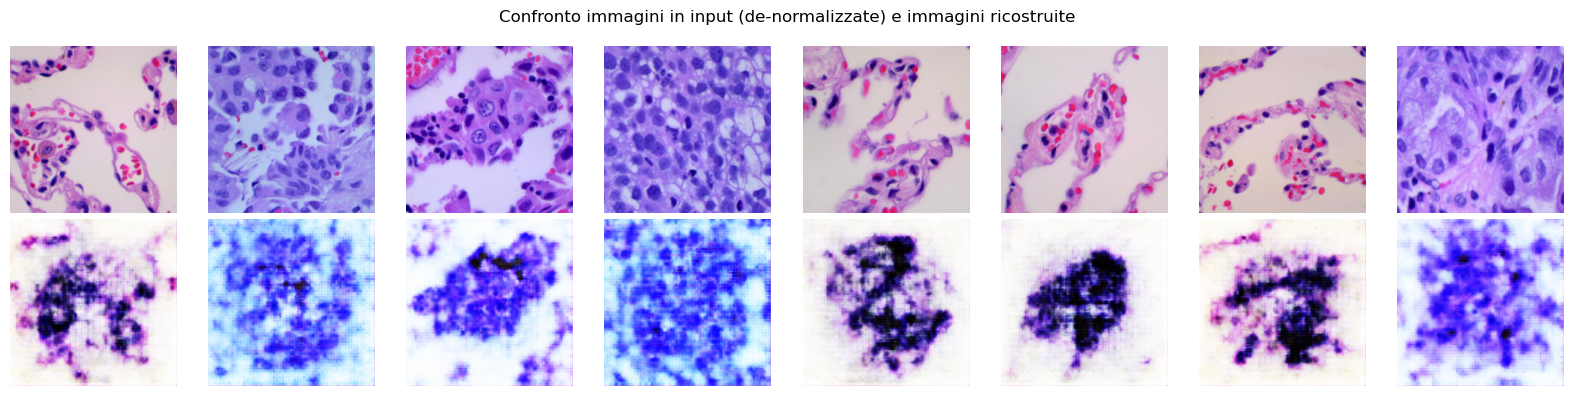

In [19]:
# confronto immagini originali vs ricostruite
model.eval()

# seleziona alcune immagini di test (normalizzate, da memmap)
samples = torch.tensor(test_data[:8], dtype=torch.float32).view(-1, 3, 224, 224).to(device)

# denormalizzazione per visualizzazione
mean_tensor = torch.tensor(mean.reshape(3, 224, 224), dtype=torch.float32).to(device)
std_tensor = torch.tensor(std.reshape(3, 224, 224), dtype=torch.float32).to(device)

# denormalizza i sample
samples_denorm = samples * std_tensor + mean_tensor
samples_denorm = torch.clamp(samples_denorm, 0.0, 1.0)

# ottieni le ricostruzioni
with torch.no_grad():
    reconstructions = model(samples).cpu()

# plot confronto
fig, axes = plt.subplots(2, 8, figsize=(16, 4))
for i in range(8):
    axes[0, i].imshow(samples_denorm[i].permute(1, 2, 0).cpu())
    axes[0, i].axis("off")
    axes[1, i].imshow(reconstructions[i].permute(1, 2, 0))
    axes[1, i].axis("off")

plt.suptitle("Confronto immagini in input (de-normalizzate) e immagini ricostruite")
plt.tight_layout()
plt.savefig(os.path.join(output_folder, "reconstruction_examples.png"))
plt.show()